# Sentiment Analysis Project for Yelp reviews

## Imports


In [135]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import string

## The Data



In [136]:
reviews = pd.read_csv("yelp.csv")

In [137]:
reviews.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [138]:
reviews.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [139]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [140]:
print(reviews['text'][0])
print("\n")
print(reviews['stars'][0])

My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!


5


## EDA

Let's explore the data



In [141]:
reviews['length'] = reviews['text'].apply(len)

In [142]:
fig = px.histogram(data_frame=reviews,x='length')
fig.show()

**A countplot of the number of occurrences for each type of star rating.**

In [143]:
px.histogram(data_frame=reviews,x='stars')

**Grids showing whenever the text length increases the Stars increases.**

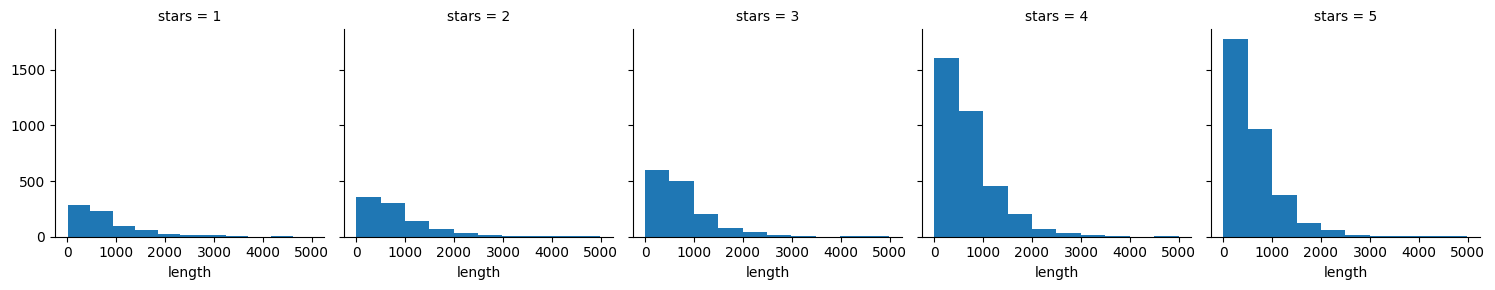

In [144]:
g = sns.FacetGrid(reviews,col='stars')
g.map(plt.hist,'length')

**Creating a boxplot of text length for each star category.**

<Axes: xlabel='stars', ylabel='length'>

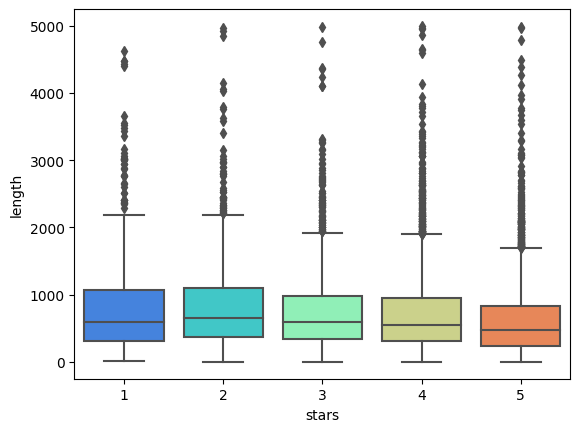

In [145]:
sns.boxplot(x='stars',y='length',data=reviews,palette='rainbow')

In [146]:
stars = reviews.groupby('stars').mean()
stars

C:\Users\Khaled\AppData\Local\Temp\ipykernel_18428\3091432401.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,cool,useful,funny,length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [147]:
stars.corr()

,cool,useful,funny,length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
length,-0.857664,0.699881,0.843461,1.000000


<Axes: >

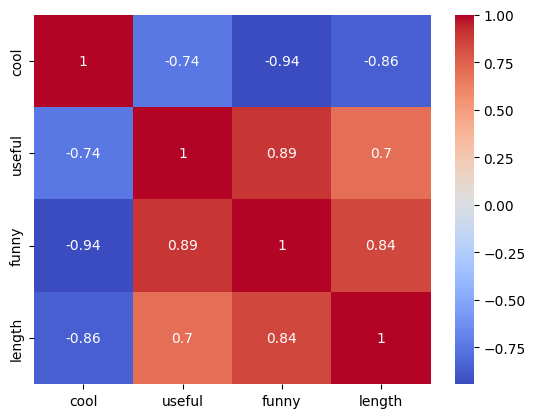

In [148]:
sns.heatmap(stars.corr(),annot=True,cmap='coolwarm')

In [149]:
reviews['date'] = pd.to_datetime(reviews['date'])

In [150]:
reviews['date'].dtype

dtype('<M8[ns]')

In [151]:
date_range = (reviews['date'].dt.date.min(), reviews['date'].dt.date.max())

In [152]:
print(date_range[0])
print(date_range[1])

2005-04-18
2013-01-05


## Preprocessing the Data

**Using Stopwords to remove the frequent words like (the , was , on)**
**,Then Stemming the data to get transform it to its Base form**
**,and Eventually lemmatizing the text to its Singular form.**

In [153]:
stop_words = stopwords.words("english")
port = PorterStemmer()
lemma = WordNetLemmatizer()

In [154]:
def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    stemmed_words = [
        lemma.lemmatize(port.stem(word)) for word in words if word not in stop_words
    ]
    return " ".join(stemmed_words)

In [155]:
reviews['processed_text'] = reviews['text'].apply(preprocess_text)

In [156]:
reviews.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,processed_text
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889,wife took birthday breakfast excel . weather p...
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345,"idea peopl give bad review place . goe show , ..."


**The Sentiment Analysis Part which indicates a text is having a positive or a negative sentiment**

In [157]:
sia = SentimentIntensityAnalyzer()

In [158]:
vader = []
for text in reviews.processed_text:
    result = sia.polarity_scores(text)
    vader.append(result)

In [159]:
vader[:3]

[{'neg': 0.0, 'neu': 0.679, 'pos': 0.321, 'compound': 0.9862},
 {'neg': 0.083, 'neu': 0.643, 'pos': 0.274, 'compound': 0.9783},
 {'neg': 0.0, 'neu': 0.496, 'pos': 0.504, 'compound': 0.7964}]

In [160]:
reviews['pos'] = [score['pos'] for score in vader]
reviews['neu'] = [score['neu'] for score in vader]
reviews['neg'] = [score['neg'] for score in vader]
reviews['compound'] = [score['compound'] for score in vader]

In [161]:
reviews.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,processed_text,pos,neu,neg,compound
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889,wife took birthday breakfast excel . weather p...,0.321,0.679,0.000,0.9862
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345,"idea peopl give bad review place . goe show , ...",0.274,0.643,0.083,0.9783


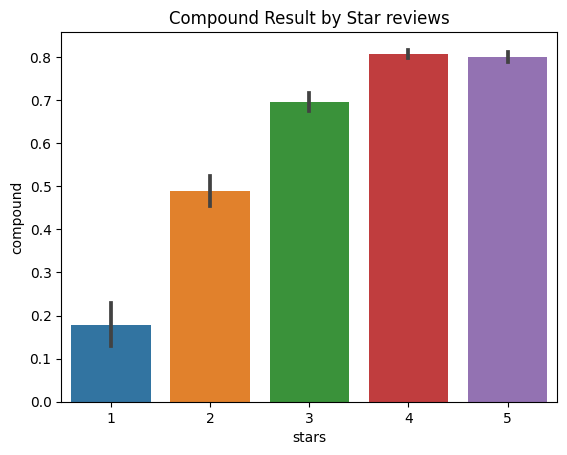

In [162]:
ax = sns.barplot(data=reviews,x='stars',y='compound')
ax.set_title("Compound Result by Star reviews");

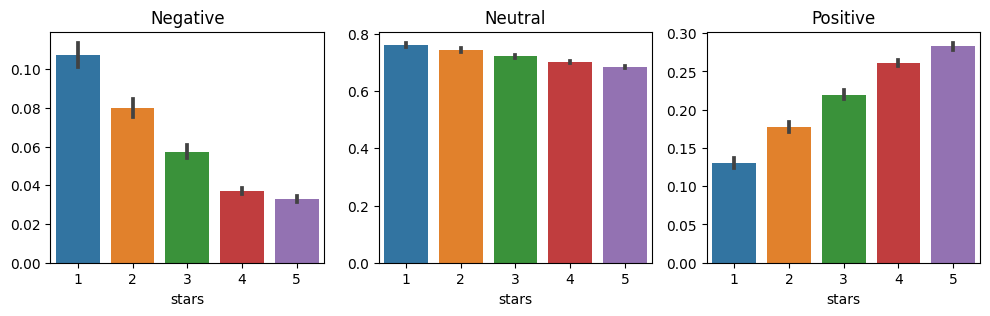

In [163]:
fig,ax = plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=reviews,x="stars",y="neg",ax=ax[0])
sns.barplot(data=reviews,x="stars",y="neu",ax=ax[1])
sns.barplot(data=reviews,x="stars",y="pos",ax=ax[2])
ax[0].set_title("Negative")
ax[1].set_title("Neutral")
ax[2].set_title("Positive")
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[2].set_ylabel(None);